In [1]:
from datetime import datetime, timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from yahooquery import Ticker
import seaborn as sns
from scipy import stats

# Coleta dos dados

CSV retirado do site [fundamentus](https://fundamentus.com.br/detalhes.php)

Adicionalmente será utilizada a biblioteca [YahooQuery](https://yahooquery.dpguthrie.com/) para coleta de dados dinâmicos realacionados a cotação

In [2]:
df = pd.read_csv('../data/2020_10_11_fundamentus.csv', index_col='ticker')

In [3]:
df.replace([np.inf, -np.inf], np.nan)
df.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,CRES_REC_(5A),ROIC,LIQUIDEZ_CORR,SETOR,SUBSETOR,DEPOSITOS,CART_DE_CREDITO,RESULT_INT_FINANC,REC_SERVICOS
ticker,,,,,,,,,,,,,,,,,,,
AALR3,2.618910e+09,9.017330e+08,3.253200e+08,5.764130e+08,6.355580e+08,1.179760e+09,9.147390e+08,-2.432000e+06,-8.448000e+07,1.182930e+08,-0.040,-0.001,0.87,SAUDE,SERVICOS_MEDICO_-_HOSPITALARES_ANALISES_E_DIAG...,NaN,NaN,NaN,NaN
ABCB3,4.989580e+10,NaN,NaN,NaN,NaN,4.093300e+09,NaN,NaN,4.187330e+08,2.183590e+08,0.028,NaN,NaN,FINANCEIROS,BANCOS,7.325720e+09,1.768990e+10,-5453950.0,292984000.0
ABCB4,4.989580e+10,NaN,NaN,NaN,NaN,4.093300e+09,NaN,NaN,4.187330e+08,2.183590e+08,0.028,NaN,NaN,FINANCEIROS,BANCOS,7.325720e+09,1.768990e+10,-5453950.0,292984000.0
ABEV3,1.213930e+11,6.782830e+09,1.748380e+10,-1.070090e+10,3.626810e+10,7.392280e+10,5.203240e+10,1.322820e+10,8.915960e+09,1.573510e+10,0.030,0.146,1.24,BEBIDAS,CERVEJAS_E_REFRIGERANTES,NaN,NaN,NaN,NaN
ABYA3,9.782870e+08,3.831590e+08,2.955600e+07,3.536030e+08,4.982220e+08,2.920600e+08,2.506570e+08,2.580200e+07,-2.398000e+06,1.049060e+08,0.164,0.028,2.09,CONSTRUCAO_E_ENGENHARIA,CONSTRUCAO_CIVIL,NaN,NaN,NaN,NaN


In [4]:
df.dtypes

ATIVO                float64
DIV_BRUTA            float64
DISPONIBILIDADES     float64
DIV_LIQUIDA          float64
ATIVO_CIRCULANTE     float64
PATRIM_LIQ           float64
RECEITA_LIQUIDA      float64
EBIT                 float64
LUCRO_LIQUIDO        float64
NRO_ACOES            float64
CRES_REC_(5A)        float64
ROIC                 float64
LIQUIDEZ_CORR        float64
SETOR                 object
SUBSETOR              object
DEPOSITOS            float64
CART_DE_CREDITO      float64
RESULT_INT_FINANC    float64
REC_SERVICOS         float64
dtype: object

### Adicionando indicadores fundamentalistas em função da cotação atual

O método `Ticker.summary_detail` retorna uma série de atributos referentes a cotação do papel em questão. O crawler do fundamentus ainda retorna algums papéis que já tiveram sua *Oferta Pública de Aquisição* (OPA) e/ou não estão mais na B3

É necessário filtrar esses ativos com ajuda da classe `Ticker`

In [5]:
# https://yahooquery.dpguthrie.com/guide/ticker/intro/
tickers = Ticker(' '.join(f'{ticker}.SA' for ticker in df.index), asynchronous=True)

In [6]:
%%time
# o atributo sumary_detail retorna um dicionario que tem como chaves os tickers (seguidos de .SA) dos papeis da B3
# quando um ticker nao esta mais disponivel (acao nao existe mais na b3) o valor dessa chave eh uma string
# aqui eh feita a filtragem baseada nesse criterio

summary_detail = tickers.summary_detail
summary_detail = [dict(ticker=k.replace('.SA', ''), **summary_detail[k]) for k in summary_detail.keys()
                 if isinstance(summary_detail[k], dict) and 'previousClose' in summary_detail[k]]

CPU times: user 4.48 s, sys: 222 ms, total: 4.7 s
Wall time: 22.7 s


In [7]:
summaries = pd.DataFrame(summary_detail)
summaries = summaries.set_index('ticker')

In [8]:
summaries.head()

,maxAge,priceHint,previousClose,open,dayLow,dayHigh,regularMarketPreviousClose,regularMarketOpen,regularMarketDayLow,regularMarketDayHigh,...,fiftyDayAverage,twoHundredDayAverage,trailingAnnualDividendRate,trailingAnnualDividendYield,currency,fromCurrency,toCurrency,lastMarket,algorithm,tradeable
ticker,,,,,,,,,,,,,,,,,,,,,
ABEV3,1,2,13.44,13.47,13.18,13.47,13.44,13.47,13.18,13.47,...,12.820556,12.979514,0.491,0.036533,BRL,None,None,None,None,False
ADHM3,1,4,2.13,2.16,2.16,2.69,2.13,2.16,2.16,2.69,...,2.065000,2.300429,NaN,NaN,BRL,None,None,None,None,False
AFLT3,1,2,9.90,10.00,10.00,10.01,9.90,10.00,10.00,10.01,...,9.983529,9.335215,0.000,0.000000,BRL,None,None,None,None,False
AALR3,1,2,11.06,11.10,10.81,11.17,11.06,11.10,10.81,11.17,...,11.294723,10.709514,0.085,0.007685,BRL,None,None,None,None,False
ABCB4,1,2,12.61,12.60,12.43,12.75,12.61,12.60,12.43,12.75,...,12.782647,13.664123,0.490,0.038858,BRL,None,None,None,None,False


In [9]:
print(len(summaries))
summaries.describe()

458


,maxAge,priceHint,previousClose,open,dayLow,dayHigh,regularMarketPreviousClose,regularMarketOpen,regularMarketDayLow,regularMarketDayHigh,...,bidSize,askSize,marketCap,fiftyTwoWeekLow,fiftyTwoWeekHigh,priceToSalesTrailing12Months,fiftyDayAverage,twoHundredDayAverage,trailingAnnualDividendRate,trailingAnnualDividendYield
count,458.0,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,458.000000,...,390.0,390.0,4.490000e+02,458.000000,458.000000,413.000000,457.000000,457.000000,301.000000,301.000000
mean,1.0,2.279476,27.263395,19.148952,26.018908,26.665349,27.263395,19.148952,26.018908,26.665349,...,0.0,0.0,1.348628e+10,16.002277,42.897449,478.455641,27.514983,25.697387,1.140983,0.045362
std,0.0,0.694188,40.672771,30.238942,39.987623,40.203060,40.672771,30.238942,39.987623,40.203060,...,0.0,0.0,3.602267e+10,24.703448,73.834890,8145.693038,39.934811,37.740595,6.400923,0.144739
min,1.0,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000e+00,0.000000,0.620000,-10.076217,0.620000,0.620000,0.000000,0.000000
25%,1.0,2.000000,8.027500,2.922500,7.160000,7.782500,8.027500,2.922500,7.160000,7.782500,...,0.0,0.0,3.499008e+08,4.000000,12.010000,0.732506,8.001667,7.346214,0.102000,0.007171
50%,1.0,2.000000,17.350000,10.985000,16.365000,17.050000,17.350000,10.985000,16.365000,17.050000,...,0.0,0.0,2.242886e+09,9.080000,25.300000,1.460979,17.139486,15.678309,0.410000,0.019708
75%,1.0,2.000000,30.107500,24.437500,28.812500,29.900000,30.107500,24.437500,28.812500,29.900000,...,0.0,0.0,9.530455e+09,19.750000,44.997500,3.397275,30.963333,29.424166,1.090000,0.043500
max,1.0,4.000000,450.000000,380.000000,450.000000,450.000000,450.000000,380.000000,450.000000,450.000000,...,0.0,0.0,3.192856e+11,299.980000,920.000000,164708.600000,415.975000,455.379580,110.507000,2.302709


In [10]:
# filtrando os ativos que não pertencem mais a B3 ou não estão disponíveis no Fundamentus
df_clean = df[pd.Series(df.index, index=df.index).isin(summaries.index)]

# e adicionando os campos COTACAO e DY retornados pelo yahoo finance
df_clean = df_clean.join(summaries[['dividendYield', 'previousClose']]).rename(columns={
    'previousClose': 'COTACAO',
    'dividendYield': 'DY'
})

Calculando os indicadores fundamentalistas

In [11]:
# LPA: Lucro por Acoes
df_clean['LPA'] = df_clean['LUCRO_LIQUIDO'] / df_clean['NRO_ACOES']

# VPA: Valor Patrimonial por Acao
df_clean['VPA'] = df_clean['PATRIM_LIQ'] / df_clean['NRO_ACOES']

# P/L: Preço sobre Lucro
df_clean['P/L'] = df_clean['COTACAO'] / df_clean['LPA']

# P/VPA: Preço sobre Valor Patrimonial
df_clean['P/VP'] = df_clean['COTACAO'] / df_clean['VPA']

# P/EBIT: Preço sobre EBIT
df_clean['P/EBIT'] = df_clean['COTACAO'] / (df_clean['EBIT'] / df_clean['NRO_ACOES'])

# MARKET_CAP: valor total das acoes ou valor de mercado
df_clean['MARKET_CAP'] = df_clean['COTACAO'] * df_clean['NRO_ACOES']

# EV: Enterprise Value == market cap + divida liquida
df_clean['EV'] = df_clean['MARKET_CAP'] + df_clean['DIV_LIQUIDA']

# EV/EBIT: Enterprise Value sobre EBIT
df_clean['EV/EBIT'] = df_clean['EV'] / df_clean['EBIT']

# MARGEM_EBIT: EBIT/RECEITA_LIQUIDA
df_clean['MARGEM_EBIT'] = df_clean['EBIT'] / df_clean['RECEITA_LIQUIDA']

# MARGEM_LIQUIDA: LUCRO_LIQUIDO/RECEITA_LIQUIDA
df_clean['MARGEM_LIQUIDA'] = df_clean['LUCRO_LIQUIDO'] / df_clean['RECEITA_LIQUIDA']

# ROE: LUCRO_LIQUIDO/PATRIM_LIQ
df_clean['ROE'] = df_clean['LUCRO_LIQUIDO'] / df_clean['PATRIM_LIQ']

# DIV_LIQ/PATR_LIQ
df_clean['DIV_LIQ/PATR_LIQ'] = df_clean['DIV_LIQUIDA'] / df_clean['PATRIM_LIQ']

In [12]:
df_clean.loc['ITSA4'] # Exemplo de Itausa, holding a que pertence o Itau

ATIVO                 6.5814e+10
DIV_BRUTA              4.981e+09
DISPONIBILIDADES       3.821e+09
DIV_LIQUIDA             1.16e+09
ATIVO_CIRCULANTE       6.799e+09
PATRIM_LIQ            5.2896e+10
RECEITA_LIQUIDA        5.002e+09
EBIT                    1.77e+08
LUCRO_LIQUIDO          7.001e+09
NRO_ACOES            8.41081e+09
CRES_REC_(5A)              0.014
ROIC                       0.003
LIQUIDEZ_CORR               2.36
SETOR                FINANCEIROS
SUBSETOR                  BANCOS
DEPOSITOS                    NaN
CART_DE_CREDITO              NaN
RESULT_INT_FINANC            NaN
REC_SERVICOS                 NaN
DY                        0.0086
COTACAO                     9.25
LPA                     0.832381
VPA                      6.28905
P/L                      11.1127
P/VP                     1.47081
P/EBIT                   439.548
MARKET_CAP              7.78e+10
EV                     7.896e+10
EV/EBIT                  446.102
MARGEM_EBIT            0.0353858
MARGEM_LIQ

# Definição de tipos

Dessa forma temos um dataset construido, com possibilidade de ter os dados de balanço patrimonial atualizados através do crawler e os dados de mercado através da api yahooquery

O dataset final tem 32 atributos, sendo 30 numéricos e 2 categóricos como mostrado abaixo

In [13]:
acoes = df_clean
# mudando o tipo de setor e subsetor de antemão
acoes['SETOR'] = acoes['SETOR'].astype('category')
acoes['SUBSETOR'] = acoes['SUBSETOR'].astype('category')
acoes.shape

(458, 33)

In [14]:
acoes.dtypes

ATIVO                 float64
DIV_BRUTA             float64
DISPONIBILIDADES      float64
DIV_LIQUIDA           float64
ATIVO_CIRCULANTE      float64
PATRIM_LIQ            float64
RECEITA_LIQUIDA       float64
EBIT                  float64
LUCRO_LIQUIDO         float64
NRO_ACOES             float64
CRES_REC_(5A)         float64
ROIC                  float64
LIQUIDEZ_CORR         float64
SETOR                category
SUBSETOR             category
DEPOSITOS             float64
CART_DE_CREDITO       float64
RESULT_INT_FINANC     float64
REC_SERVICOS          float64
DY                    float64
COTACAO               float64
LPA                   float64
VPA                   float64
P/L                   float64
P/VP                  float64
P/EBIT                float64
MARKET_CAP            float64
EV                    float64
EV/EBIT               float64
MARGEM_EBIT           float64
MARGEM_LIQUIDA        float64
ROE                   float64
DIV_LIQ/PATR_LIQ      float64
dtype: obj

# Tratamento de dados ausentes

- É possível perceber que há uma divisão entre pelo menos dois tipos distintos de ações dado que o total é 458 e vários atributos estão com 42 ou 416 dados ausentes. Ou seja, há uma divisão clara, provavelmente entre empresas do subsetor bancário e as outras.

In [15]:
acoes.isna().sum()

ATIVO                  0
DIV_BRUTA             42
DISPONIBILIDADES      42
DIV_LIQUIDA           42
ATIVO_CIRCULANTE      42
PATRIM_LIQ             0
RECEITA_LIQUIDA       42
EBIT                  42
LUCRO_LIQUIDO          0
NRO_ACOES              0
CRES_REC_(5A)         37
ROIC                  74
LIQUIDEZ_CORR         61
SETOR                  0
SUBSETOR               0
DEPOSITOS            416
CART_DE_CREDITO      416
RESULT_INT_FINANC    416
REC_SERVICOS         416
DY                   188
COTACAO                0
LPA                    0
VPA                    0
P/L                    0
P/VP                   0
P/EBIT                42
MARKET_CAP             0
EV                    42
EV/EBIT               42
MARGEM_EBIT           60
MARGEM_LIQUIDA        60
ROE                    4
DIV_LIQ/PATR_LIQ      46
dtype: int64

<AxesSubplot:>

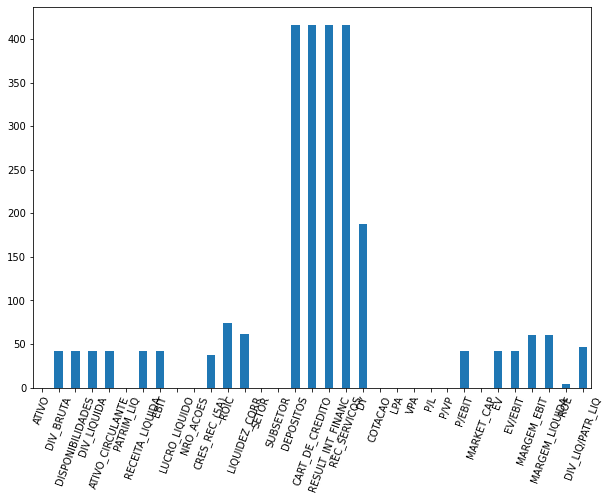

In [16]:
acoes.isna().sum().plot.bar(rot=70, figsize=(10, 7))

(54, 33)
(54, 33)


<AxesSubplot:>

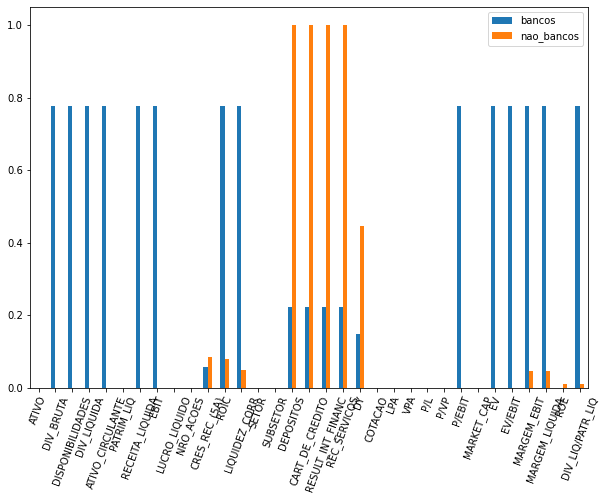

In [17]:
bancos = acoes[acoes['SUBSETOR'].isin(['BANCOS', 'SOC_CREDITO_E_FINANCIAMENTO'])]
print(bancos.shape)

comuns = acoes[~acoes['SUBSETOR'].isin(['BANCOS', 'SOC_CREDITO_E_FINANCIAMENTO'])]
print(bancos.shape)

pd.DataFrame({'bancos':bancos.isna().sum()/len(bancos), 'nao_bancos':comuns.isna().sum()/len(comuns)}).plot.bar(rot=70, figsize=(10, 7))

A estratégia de inputação dos dados ausentes aqui vai se basear no subsetor de cada ativo, mais especificamente nessa divisião entre setor bancário/outros setores.

Para os que pertencem ao setor bancário, os atributos que são característicos desse setor (`DEPOSITOS`, `CART_DE_CREDITO`, etc) serão imputados com zero juntamente com os que não pertencem a esse setor pois são apenas 3 empresas (`BRGE`, `ITSA`, `RPAD`), que na verdade são holdings ou consórcios financeiros que possuem valores ausentes, então serão tratadas como empresas comuns.
O contrário também será aplicado.

In [18]:
# AS EMPRESAS QUE ESTAO NO SUBSETOR BANCARIO E POSSUEM VALORES AUSENTES PARA ATRIBUTOS
# CARACTERISTICOS DESSE SUBSETOR SÃO APENAS 3
bancos[(bancos['DEPOSITOS'].isna()) | (bancos['CART_DE_CREDITO'].isna())
       | (bancos['RESULT_INT_FINANC'].isna()) | (bancos['REC_SERVICOS'].isna())].index

Index(['BRGE11', 'BRGE12', 'BRGE3', 'BRGE5', 'BRGE6', 'BRGE7', 'BRGE8',
       'ITSA3', 'ITSA4', 'RPAD3', 'RPAD5', 'RPAD6'],
      dtype='object', name='ticker')

In [19]:
attrs_bancos = ['DEPOSITOS', 'CART_DE_CREDITO', 'RESULT_INT_FINANC', 'REC_SERVICOS']

bancos[attrs_bancos] = bancos[attrs_bancos].fillna(value=0)
comuns[attrs_bancos] = comuns[attrs_bancos].fillna(value=0)


attrs_comuns = ['DIV_BRUTA', 'DISPONIBILIDADES', 'DIV_LIQUIDA', 'ATIVO_CIRCULANTE', 'PATRIM_LIQ',
                'RECEITA_LIQUIDA', 'EBIT', 'ROIC', 'LIQUIDEZ_CORR', 'P/EBIT', 'EV', 'EV/EBIT',
                'MARGEM_EBIT', 'MARGEM_LIQUIDA', 'DIV_LIQ/PATR_LIQ']

bancos[attrs_comuns] = bancos[attrs_comuns].fillna(value=0)

/home/adilson/.anaconda3/envs/if697/lib/python3.8/site-packages/pandas/core/frame.py:3065: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


<AxesSubplot:>

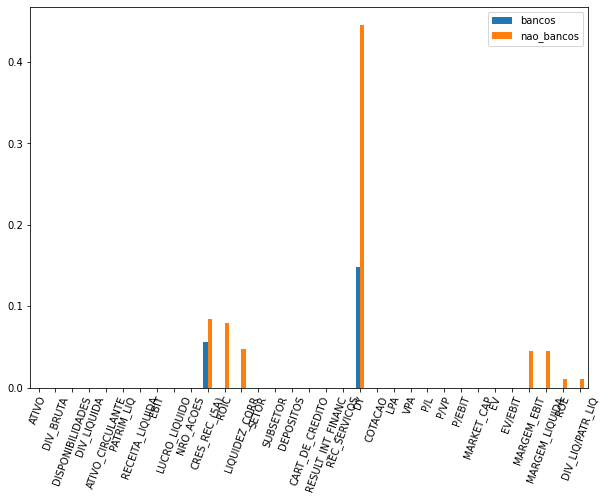

In [20]:
pd.DataFrame(
    {'bancos': bancos.isna().sum()/len(bancos), 'nao_bancos': comuns.isna().sum()/len(comuns)}
).plot.bar(rot=70, figsize=(10, 7))

O DY (Dividend Yield) especificamente será imputado com valor zero, há empresas que pagam dividendo e outras que não.

In [21]:
acoes = pd.concat([bancos, comuns])

In [22]:
acoes['DY'] = acoes['DY'].fillna(0)

<AxesSubplot:>

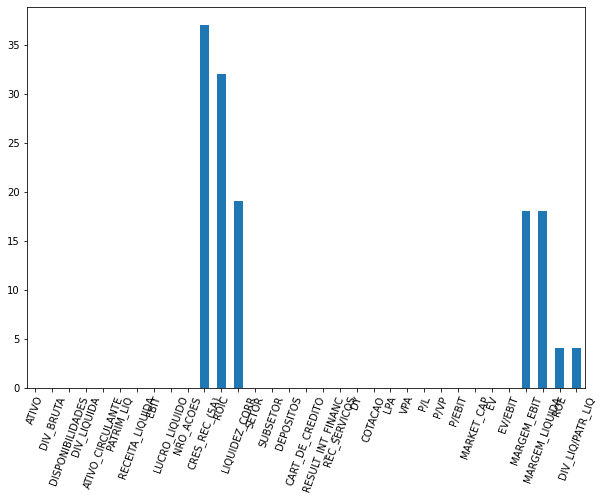

In [23]:
acoes.isna().sum().plot.bar(rot=70, figsize=(10, 7))

**Para valores ausentes restantes** será utilizado o **KNNImputer** do sklearn, e para isso é preciso codificar numericamente os atributos categóricos e normalizar os valores para a extensão dos atributos não influenciar o cálculo da distância no KNN

In [24]:
# One hot encoding com .get_dummies
acoes_c = pd.get_dummies(acoes, drop_first=True)
acoes_c = acoes_c.replace([np.inf, -np.inf], np.nan)
acoes_c.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,4.989580e+10,0.0,0.0,0.0,0.0,4.093300e+09,0.0,0.0,4.187330e+08,2.183590e+08,...,0,0,0,0,0,0,0,0,0,0
BAZA3,2.051230e+10,0.0,0.0,0.0,0.0,2.316530e+09,0.0,0.0,3.250920e+08,2.964600e+07,...,0,0,0,0,0,0,0,0,0,0
BBAS3,1.780470e+12,0.0,0.0,0.0,0.0,1.050070e+11,0.0,0.0,1.612730e+10,2.865420e+09,...,0,0,0,0,0,0,0,0,0,0
BBDC3,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0,0,0,0,0,0,0,0,0,0
BBDC4,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0,0,0,0,0,0,0,0,0,0


In [25]:
acoes_norm = (acoes_c - acoes_c.min()) / (acoes_c.max() - acoes_c.min())
acoes_norm.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,0.028024,0.0,0.0,0.033805,0.0,0.066841,0.004307,0.031023,0.638280,0.013876,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAZA3,0.011521,0.0,0.0,0.033805,0.0,0.059894,0.004307,0.031023,0.636544,0.001883,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBAS3,1.000000,0.0,0.0,0.033805,0.0,0.461392,0.004307,0.031023,0.929623,0.182103,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC3,0.746724,0.0,0.0,0.033805,0.0,0.579182,0.004307,0.031023,0.957088,0.563721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,0.746724,0.0,0.0,0.033805,0.0,0.579182,0.004307,0.031023,0.957088,0.563721,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [26]:
from sklearn.impute import KNNImputer
imputer = KNNImputer(missing_values=np.nan, n_neighbors=5)

In [27]:
acoes_one_hot = pd.DataFrame(imputer.fit_transform(acoes_norm), index=acoes_norm.index, columns=acoes_norm.columns)

Desfazendo a normalização

In [28]:
acoes_one_hot = acoes_one_hot * (acoes_c.max() - acoes_c.min()) + acoes_c.min()

In [29]:
acoes_one_hot.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,4.989580e+10,0.0,0.0,0.0,0.0,4.093300e+09,0.0,0.0,4.187330e+08,2.183590e+08,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BAZA3,2.051230e+10,0.0,0.0,0.0,0.0,2.316530e+09,0.0,0.0,3.250920e+08,2.964600e+07,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBAS3,1.780470e+12,0.0,0.0,0.0,0.0,1.050070e+11,0.0,0.0,1.612730e+10,2.865420e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC3,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [30]:
# sem valores vazios :)

acoes_one_hot.isna().sum()[acoes_one_hot.isna().sum() > 0]

Series([], dtype: int64)

In [31]:
# desfazendo one hot encoding
acoes_full = acoes_one_hot.copy()
acoes_full['SETOR'] = acoes['SETOR'].astype('category')
acoes_full['SUBSETOR'] = acoes['SUBSETOR'].astype('category')

acoes_full = acoes_full.drop(columns=[col for col in acoes_full if col.startswith('SETOR_') or col.startswith('SUBSETOR_')])

In [32]:
acoes_full.head()

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,P/EBIT,MARKET_CAP,EV,EV/EBIT,MARGEM_EBIT,MARGEM_LIQUIDA,ROE,DIV_LIQ/PATR_LIQ,SETOR,SUBSETOR
ticker,,,,,,,,,,,,,,,,,,,,,
ABCB4,4.989580e+10,0.0,0.0,0.0,0.0,4.093300e+09,0.0,0.0,4.187330e+08,2.183590e+08,...,0.0,2.753507e+09,2.384186e-07,0.0,0.0,-5.684342e-14,0.102297,3.552714e-15,FINANCEIROS,BANCOS
BAZA3,2.051230e+10,0.0,0.0,0.0,0.0,2.316530e+09,0.0,0.0,3.250920e+08,2.964600e+07,...,0.0,1.151747e+09,2.384186e-07,0.0,0.0,-5.684342e-14,0.140336,3.552714e-15,FINANCEIROS,BANCOS
BBAS3,1.780470e+12,0.0,0.0,0.0,0.0,1.050070e+11,0.0,0.0,1.612730e+10,2.865420e+09,...,0.0,8.899995e+10,2.384186e-07,0.0,0.0,-5.684342e-14,0.153583,3.552714e-15,FINANCEIROS,BANCOS
BBDC3,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,1.700419e+11,2.384186e-07,0.0,0.0,-5.684342e-14,0.130302,3.552714e-15,FINANCEIROS,BANCOS
BBDC4,1.329520e+12,0.0,0.0,0.0,0.0,1.351340e+11,0.0,0.0,1.760820e+10,8.870210e+09,...,0.0,1.839682e+11,2.384186e-07,0.0,0.0,-5.684342e-14,0.130302,3.552714e-15,FINANCEIROS,BANCOS


# Limpeza dos dados


### Univariados

Analisando atributo comum aos dois tipos de ações citados anteriormente

ShapiroResult(statistic=nan, pvalue=1.0)

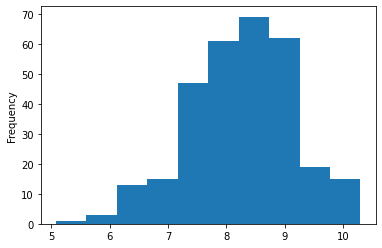

In [33]:
acoes_full['LUCRO_LIQUIDO'].apply(np.log10).plot.hist()
stats.shapiro(acoes_full['LUCRO_LIQUIDO'].apply(np.log10))

In [34]:
LL_log = acoes_full['LUCRO_LIQUIDO'].apply(np.log10)
mad = abs(LL_log - LL_log.median()).median() / .6745
acoes_full[abs(LL_log - LL_log.median()) / mad > 3.5]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,P/EBIT,MARKET_CAP,EV,EV/EBIT,MARGEM_EBIT,MARGEM_LIQUIDA,ROE,DIV_LIQ/PATR_LIQ,SETOR,SUBSETOR
ticker,,,,,,,,,,,,,,,,,,,,,


<AxesSubplot:ylabel='Frequency'>

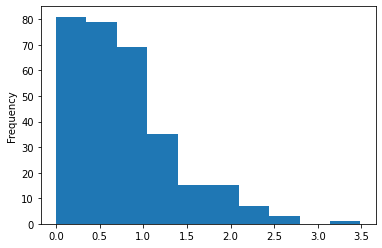

In [35]:
(abs(LL_log - LL_log.median()) / mad).plot.hist()

### Bivariados

Analisando a relação Margem Líquida - Dívida Líquida/Patrimônio Líquido. Idealmente, quando maior a Margem Líquida e menor a Dívida Líquida/Patrimônio Líquido, melhor.

In [36]:
stats.shapiro(acoes_full['DIV_LIQ/PATR_LIQ'].apply(np.log10))

ShapiroResult(statistic=nan, pvalue=1.0)

In [37]:
stats.shapiro(acoes_full['MARGEM_LIQUIDA'].apply(np.log10))

ShapiroResult(statistic=nan, pvalue=1.0)

<AxesSubplot:xlabel='MARGEM_LIQUIDA', ylabel='DIV_LIQ/PATR_LIQ'>

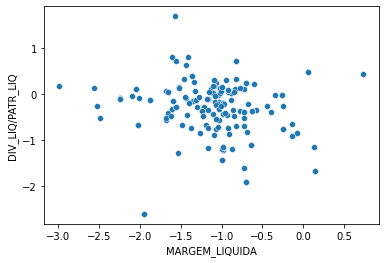

In [38]:
sns.scatterplot(x=acoes_full['MARGEM_LIQUIDA'].apply(np.log10), y=acoes_full['DIV_LIQ/PATR_LIQ'].apply(np.log10))

Nesse caso os outliers seriam de interesse, como é o caso de Itaúsa abaixo

In [39]:
acoes_full[(acoes_full['MARGEM_LIQUIDA'].apply(np.log10) > .1) & (acoes_full['DIV_LIQ/PATR_LIQ'].apply(np.log10) < 0)]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,P/EBIT,MARKET_CAP,EV,EV/EBIT,MARGEM_EBIT,MARGEM_LIQUIDA,ROE,DIV_LIQ/PATR_LIQ,SETOR,SUBSETOR
ticker,,,,,,,,,,,,,,,,,,,,,
ITSA3,6.581400e+10,4.981000e+09,3.821000e+09,1.160000e+09,6.799000e+09,5.289600e+10,5.002000e+09,177000000.0,7.001000e+09,8.410810e+09,...,503.698226,8.915459e+10,9.031459e+10,510.251898,0.035386,1.399640,0.132354,0.021930,FINANCEIROS,BANCOS
ITSA4,6.581400e+10,4.981000e+09,3.821000e+09,1.160000e+09,6.799000e+09,5.289600e+10,5.002000e+09,177000000.0,7.001000e+09,8.410810e+09,...,439.547980,7.779999e+10,7.895999e+10,446.101653,0.035386,1.399640,0.132354,0.021930,FINANCEIROS,BANCOS
BRPR3,9.916320e+09,1.759630e+09,1.255720e+09,5.039120e+08,1.517320e+09,7.166500e+09,3.342860e+08,217616000.0,4.564880e+08,4.915100e+08,...,20.666295,4.497316e+09,5.001228e+09,22.981897,0.650987,1.365561,0.063697,0.070315,EXPLORACAO_DE_IMOVEIS,EXPLORACAO_DE_IMOVEIS



### Multivariados
Ainda temos 147 atributos depois do *one hot encoding*

Para detectar outliers com esse número de features será utilizado o Isolation Forest e o Local Outlier Factor, já que eles não são paramétricos

In [40]:
from sklearn.ensemble import IsolationForest

In [41]:
iforest = IsolationForest(contamination=.01, random_state=0)
acoes_one_hot[pd.Series(iforest.fit_predict(acoes_one_hot), index=acoes_one_hot.index) == -1]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
BBDC3,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR3,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR4,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
VALE3,4.553030e+11,1.016080e+11,6.633310e+10,3.527500e+10,1.111950e+11,1.869590e+11,1.533680e+11,6.342340e+10,6.407460e+09,5.284470e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
from sklearn.neighbors import LocalOutlierFactor

lof = LocalOutlierFactor(n_neighbors=25, contamination=0.01)

acoes_one_hot[pd.Series(lof.fit_predict(acoes_one_hot), index=acoes_one_hot.index) == -1]

,ATIVO,DIV_BRUTA,DISPONIBILIDADES,DIV_LIQUIDA,ATIVO_CIRCULANTE,PATRIM_LIQ,RECEITA_LIQUIDA,EBIT,LUCRO_LIQUIDO,NRO_ACOES,...,SUBSETOR_TECIDOS_VESTUARIO_E_CALCADOS,SUBSETOR_TELEFONIA_FIXA,SUBSETOR_TELEFONIA_MOVEL,SUBSETOR_TRANSPORTE_AEREO,SUBSETOR_TRANSPORTE_FERROVIARIO,SUBSETOR_TRANSPORTE_HIDROVIARIO,SUBSETOR_TRANSPORTE_RODOVIARIO,SUBSETOR_UTENSILIOS_DOMESTICOS,SUBSETOR_VESTUARIO,SUBSETOR_VIAGENS_E_TURISMO
ticker,,,,,,,,,,,,,,,,,,,,,
BBAS3,1.780470e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.050070e+11,0.000000e+00,0.000000e+00,1.612730e+10,2.865420e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC3,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
BBDC4,1.329520e+12,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.351340e+11,0.000000e+00,0.000000e+00,1.760820e+10,8.870210e+09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR3,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
PETR4,1.015140e+12,4.995550e+11,1.095500e+11,3.900050e+11,2.019260e+11,2.427660e+11,2.760460e+11,8.545400e+10,-3.399600e+10,1.304450e+10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Dada a relevância dos ativos dados como outliers pelos métodos utilizados acima, não será feita a remoção desses outliers do dataset pois outliers nesse domínio são bem-vindos

# Estatísticas Descritivas

Para análise fundamentalista os ativos mais interessantes são aqueles que pertencem a empresas sólidas e pagam bons dividendos

Os indicadores financeiros que medem a saúde financeira de uma empresa, assim como sua rentabilidade são:

- ROE (Return on Equity);
    - Quanto de lucro uma empresa gera pra cada Real próprio investido nela

- ROIC (Return on Invested Capital);
    - Quanto de lucro uma empresa gera pra cada Real próprio e de terceiros investido nela
    
- Dívida Líquida sobre Patrimônio Liquido;
    - O quanto do patrimônio líquido da empresa equivale à dívida líquida, ou seja, o nível de dívida dela. Ideal é abaixo de 50%

- Margem EBIT;
    - Resultado operacional sobre a receita líquida; Mostra o lucro operacional realizado para cada "venda", quanto maior melhor (teoricamente)

- Margem Líquida;
    - Lucro Líquido/Receita Líquida; a porcentagem de lucro por venda realizada

Abaixo é possível observar que existe uma variedade muito grande nos valores dos indicadores, é comum ter outliers nos boxes mesmo numa escala logaritmica

<AxesSubplot:>

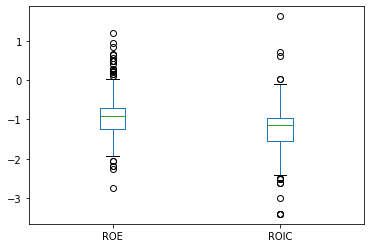

In [43]:
acoes_full[['ROE', 'ROIC']].apply(np.log10).plot.box()

<AxesSubplot:>

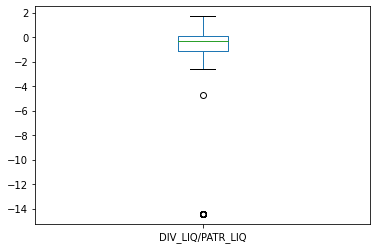

In [44]:
acoes_full[['DIV_LIQ/PATR_LIQ']].apply(np.log10).plot.box()

In [45]:
acoes_full[acoes_full['DIV_LIQ/PATR_LIQ'] == acoes_full['DIV_LIQ/PATR_LIQ'].min()]['DIV_LIQ/PATR_LIQ']

ticker
FRIO3   -28.235628
Name: DIV_LIQ/PATR_LIQ, dtype: float64

<AxesSubplot:>

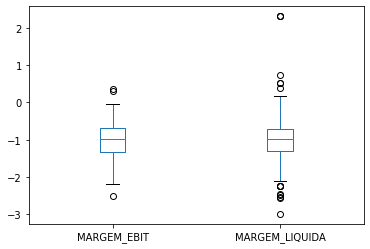

In [46]:
acoes_full[['MARGEM_EBIT', 'MARGEM_LIQUIDA']].apply(np.log10).plot.box()

# Testes de Hipótese

Serão analisadas as influências dos indicadores fundamentalistas citados acima na geração de dividendos das empresas

Como o **Dividend Yield** das empresas não segue uma distribuição gaussiana, será necessário usar testes não-paramétricos. 

ShapiroResult(statistic=0.6530007123947144, pvalue=1.8729154124758853e-29)


<AxesSubplot:ylabel='Frequency'>

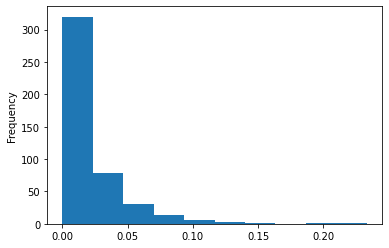

In [47]:
print(stats.shapiro(acoes_full['DY']))
acoes_full['DY'].plot.hist()

Era esperado que os indicadores acima tivessem uma correlação maior no **DY** da empresa, mas o que mais influenciou positivamente foi o Lucro Líquido e ele influencia diretamente somente o indicador Margem Líquida

<AxesSubplot:>

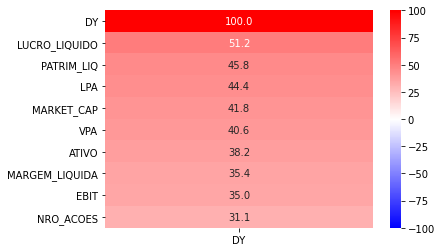

In [48]:
corrs = acoes_full.corr(method='spearman')

sns.heatmap(corrs[['DY']].sort_values(by=['DY'], ascending=False).iloc[:10] * 100,
            annot=True, fmt = '.1f', vmin=-100, vmax=100, cmap='bwr')

Entretando DY por si só não quer dizer muita coisa pois depende do momento e da cotação, é necessário ver como os indicadores de saúde financeira se relacionam entre si.

De acordo com a [Suno Research](https://www.sunoresearch.com.br/artigos/os-indicadores-mais-importantes-em-uma-analise/) uma boa **Margem Líquida**, por exemplo, em geral está acima de 10%

Abaixo serão testados os indicadores separando a população de acordo com o valor de 15% de **Margem Líquida**. A hipótese nula é de que essas duas populações tem médias de indicadores iguais, e a hipótese alternativa é de que para empresas de **ML** >= 15% esses indicadores tem média maior (no caso da Dívida Líquida/Patrimônio Líquido a hipótese alternativa é que é menor).

Será utilizado teste de Mann-Whitney já que a Margem Líquida não segue uma distribuição normal e serão comparados dois grupos não pariados

In [49]:
# Margem Líquida não segue uma distribuição normal
SIGNIFICANCIA = .01

print(f'MARGEM_LIQUIDA eh gaussiana: {stats.shapiro(acoes_full["MARGEM_LIQUIDA"]).pvalue > SIGNIFICANCIA}')
print()

ML_maior = acoes_full[acoes_full['MARGEM_LIQUIDA'] >= .15]
ML_menor = acoes_full[acoes_full['MARGEM_LIQUIDA'] < .15]

p_value_ROIC = stats.mannwhitneyu(ML_maior['ROIC'], ML_menor['ROIC'], alternative='greater').pvalue
p_value_ROE = stats.mannwhitneyu(ML_maior['ROE'], ML_menor['ROE'], alternative='greater').pvalue
p_value_DIVLIQ_PATLIQ = stats.mannwhitneyu(ML_maior['DIV_LIQ/PATR_LIQ'], ML_menor['DIV_LIQ/PATR_LIQ'], alternative='less').pvalue
p_value_MARGEM_EBIT = stats.mannwhitneyu(ML_maior['MARGEM_EBIT'], ML_menor['MARGEM_EBIT'], alternative='greater').pvalue

print(f'ROIC Hipótese nula: {"ACEITA" if p_value_ROIC > SIGNIFICANCIA else "REJEITADA"}')
print()
print(f'ROE Hipótese nula: {"ACEITA" if p_value_ROE > SIGNIFICANCIA else "REJEITADA"}')
print()
print(f'DIV_LIQ/PATR_LIQ Hipótese nula: {"ACEITA" if p_value_DIVLIQ_PATLIQ > SIGNIFICANCIA else "REJEITADA"}')
print()
print(f'MARGEM_EBIT Hipótese nula: {"ACEITA" if p_value_MARGEM_EBIT > SIGNIFICANCIA else "REJEITADA"}')


MARGEM_LIQUIDA eh gaussiana: False

ROIC Hipótese nula: REJEITADA

ROE Hipótese nula: REJEITADA

DIV_LIQ/PATR_LIQ Hipótese nula: REJEITADA

MARGEM_EBIT Hipótese nula: REJEITADA


Os indicadores considerados relevantes para saúde financeira se comportaram como esperado de acordo com os analistas do mercado financeiro.